In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Defining loss functions, transfer functions, and a meta function

In [4]:
  def mae_loss(y, y_pred, grad = False):
    if grad:
        if y > y_pred:
          return(-1)
        else:
          return(1)
    else:
      return(np.abs(y - y_pred))

  def mse_loss(y, y_pred, grad = False):
    if grad: 
      return(y_pred - y)
    else:
      return(np.square(y_pred - y))

  def cross_entropy(y, y_pred, grad = False):
    y_pred = np.where(y_pred == 0, 0.001, y_pred)
    ## this isn't correct
    if grad:
      return(-y/y_pred)
    else:
      return(-y * np.log(y_pred))

    
#######
  def identity(x, grad = False):
    if grad:
      return(1)
    else:
      return(x)

  def sigm_stable(x):
      if x < 0:
        return(np.exp(x)/(1 + np.exp(x)))
      else:
        return(1/(1 + np.exp(-x)))

  sigm_stable_v = np.vectorize(sigm_stable)

  def sigmoid(x, grad = False):
    #sigmoid = np.apply_along_axis(func1d = sigm_stable_v, axis = 1, arr = x)

    x = np.where(x < -100, -100, x)

    sigmoid = 1/(1 + np.exp(-x))

    if grad:
      return(sigmoid*(1-sigmoid))
    else: 
      return(sigmoid)

  # for the softmax the output needs to have n layers
  def softmax(x, grad = False):
    x = np.where(x < -100, -100, x)
    b = np.max(x, axis = 0)
    s = np.sum(np.exp(x - b), axis = 0)
    sm = np.exp(x - b) / s
    if grad:
      return(sm*(1-sm))
    else:
      return(sm)


  def leaky_relu(x, grad = False):
    x = np.where(x==0, 0.01, x)
    if grad:
      return(np.where(x < 0, -0.01, 1))
    else: 
      return(np.where(x < 0, x*0.01, x))

  def transfer(x, f, grad = False):
      return(f(x, grad = grad))


# A class for a Neural Net that can act as a Regression and a Classifier


In [260]:
class NN:
  def __init__(self, nr_features, layers, loss_function):
    
    # add checks that the input is correct

    # Nr or examples in the input
    self.nr_features = nr_features
    # list with tuples (size, transferfunction)
    self.layers = layers
    self.nr_layers = len(layers)
    self.loss_function = loss_function

    self.W = [np.random.randn(layers[0][0], self.nr_features)] # list of weights per layer
    self.B = [np.random.randn(layers[0][0], 1)]  # list of biases per layers
    self.F = [layers[0][1]]                      # list of activation functions per layer

    for i in np.arange(1, len(layers)):  # fill the lists using the list layers
      self.W.append(np.random.randn(layers[i][0], layers[i-1][0]))
      self.B.append(np.random.randn(layers[i][0], 1))
      self.F.append(layers[i][1])

    self.A = [0 for i in self.F]           # list of outputs per layer
    self.Z = [0 for i in self.F]           # list of inputs per layer
    self.D = [0 for i in self.F]           # list of deltas per layer

##############

  def forward_pass(self, X):
    self.Z[0] = self.W[0] @ X + self.B[0]
    self.A[0] = transfer(f = self.F[0], x = self.Z[0]) 

    for i in np.arange(1, self.nr_layers):   

      self.Z[i] = self.W[i] @ self.A[i-1] + self.B[i]     
      self.A[i] = transfer(f = self.F[i], x = self.Z[i]) 

  def evaluate(self, y, y_pred):
    loss = self.loss_function(y = y, y_pred = y_pred)
    return(loss)

#############

  def backprop(self, X, y, learning_rate):

    ## error of output
    last = self.nr_layers-1

    ## is loss is cross entropy, the last layer must be softmax in order for this to 
    ## be correct, check for that! 
    if self.loss_function == cross_entropy:
      self.D[last] = self.A[last] - y
    else: 
      error = self.loss_function(y = y, y_pred = self.A[last], grad = True)  
      self.D[last] = error * transfer(f = self.F[last], x = self.Z[last], grad = True)
    
    one_vec = np.ones([self.D[last].shape[1], 1])

    ## propagate through all layers
    for i in np.arange(self.nr_layers-2, -1, -1):
      error = self.W[i+1].T @ self.D[i+1]
      self.D[i] = error * transfer(f = self.F[i], x = self.Z[i], grad = True)

    ## adjust weights
    self.W[0] -= self.D[0] @ X.T * learning_rate
    self.B[0] -= self.D[0] @ one_vec  * learning_rate

    for i in np.arange(1, self.nr_layers):
      self.W[i] -=  (self.D[i] @ self.A[i-1].T) * learning_rate
      self.B[i] -=  (self.D[i] @ one_vec) * learning_rate

  def get_weights(self):
    return(self.W)

  def train(self, X, y, nr_iterations, learning_rate, track = False):

    self.evaluations = []

    for iteration in np.arange(nr_iterations): 
      self.forward_pass(X)

      #print(np.sum(self.evaluate(y)))
      if ((iteration % 1000 == 999) & track): 
        eval = np.sum(self.evaluate(y = y, y_pred = self.A[self.nr_layers-1]))
        self.evaluations.append(eval)

      self.backprop(X, y, learning_rate)

  def predict(self, X):
    self.forward_pass(X)
    return(self.A[self.nr_layers-1])

  def plot(self, color = 'b'):
    x = np.arange(len(self.evaluations)) * 1000
    y = self.evaluations
    plt.plot(x, y, c=color)
    plt.xlabel('Iterations')
    plt.ylabel('loss')
    plt.title('Training progress')

  def get_evaluations(self):
    return(self.evaluations)


# Trying it with some data
- first dataset
- mostly using leaky relu
- 5 layers
- linear output layer

In [66]:
# The last layer must be of size 1
layers = [(3, leaky_relu), (4, sigmoid), (5, leaky_relu), (5, leaky_relu), (1, identity)]

np.random.seed(9)
X = np.random.randn(1, 100)*5 + 5
y = 3*X + 2*np.random.randn(1, 100)

In [67]:
regr_net_1 = NN(nr_features = 1, layers = layers, loss_function = mse_loss)
regr_net_1.train(X, y, nr_iterations = 50000, learning_rate = 0.0001, track = True)

[1147.4235238720564, 1117.9427899375398, 1126.385564592458, 1117.1487414281153, 1116.9544413337248, 1115.546015340297, 1115.8964304489577, 1115.667977638043, 1115.4664450582018, 1114.3710034057387, 1110.7337279619226, 1102.6051565406963, 1104.669540495341, 888.1568910184953, 605.8145135078814, 701.7496058268159, 2404.972199099401, 1254.543920531236, 916.9554915864038, 727.8156197935714, 813.7050285691248, 532.4241469264379, 548.8935276481395, 1000.7737538995142, 623.7960915428264, 964.7115791626181, 616.1763954223151, 536.4722883705115, 852.115338856582, 842.6456777388081, 860.9417320733179, 849.9551657892082, 847.0042042697257, 861.337519370949, 860.8943266825416, 860.5481522615905, 854.4080816951043, 876.00067227344, 833.5758741714498, 850.4041445157566, 849.4002509746501, 845.6118183179511, 835.0938240352617, 834.3492008086565, 847.7200454318299, 833.5340387372902, 843.4715955082727, 834.2622408309124, 840.0726051967957, 840.5322436159861]


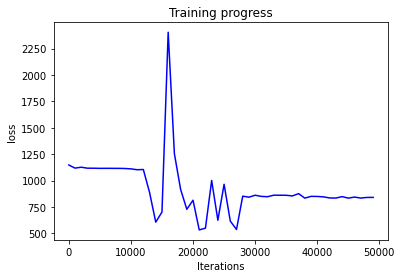

In [61]:
print(regr_net_1.get_evaluations())
regr_net_1.plot()


In [68]:
regr_net_1.predict(X = [[2,3,1,1,3,2]])

array([[6.99904684, 8.28741894, 3.72049659, 3.72049659, 8.28741894,
        6.99904684]])

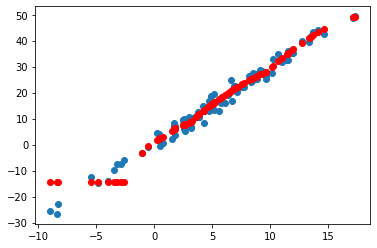

In [72]:
plt.scatter(x = X, y = y)
plt.scatter(x = X, y = regr_net_1.predict(X), c = 'r')

Text(0.5, 1.0, 'residuals vs fitted')

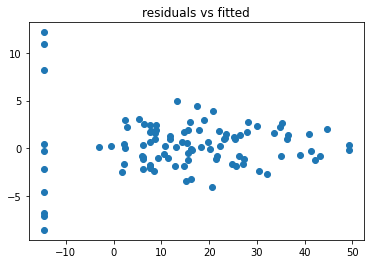

In [74]:
residuals = regr_net_1.predict(X) - y
plt.scatter(x = regr_net_1.predict(X), y = residuals)
plt.title("residuals vs fitted")

# Another Regression 
- binary classification
- 4 layers
- sigmoid output layer

In [77]:
# The last layer must be of size 1
layers = [(3, sigmoid), (4, leaky_relu), (5, identity), (1, sigmoid)]

np.random.seed(9)
X = np.random.randn(1, 100)*5 + 5
y = np.where(X + np.random.randn(1, 100) > 5, 1, 0) 

In [78]:
regr_net_2 = NN(nr_features = 1, layers = layers, loss_function = mse_loss)
regr_net_2.train(X, y, nr_iterations = 50000, learning_rate = 0.0001, track = True)

[7.714512084103329, 6.337632002518842, 5.804746209312318, 5.53685670849222, 5.366499443146117, 5.240435000984234, 5.164735225253564, 5.0954365159576165, 4.984788301421364, 4.967293023518114, 4.9531422514311725, 4.941546142461835, 4.93194408664049, 4.923731088989937, 4.916949309457445, 4.911000034592877, 4.906040675320396, 4.901752586732583, 4.89807770967446, 4.8948222799052425, 4.891970423510965, 4.889633750859111, 4.887394501489886, 4.885571280300939, 4.88392357353033, 4.882503836654552, 4.881190693342467, 4.88005566234433, 4.87900239921358, 4.878113072901237, 4.877294533315414, 4.87651527308284, 4.875899804065616, 4.875176806368048, 4.874708187777053, 4.874227480593519, 4.873692263504375, 4.873262627372757, 4.872896944534733, 4.872551135742414, 4.872198704530506, 4.8718301112919775, 4.871542774388529, 4.871331638722561, 4.871094010485871, 4.870847203471427, 4.870536244945787, 4.870326874731046, 4.870202439838737, 4.869886983532852]
[[6.99904684 8.28741894 3.72049659 3.72049659 8.2874

Text(0.5, 1.0, 'residuals vs fitted')

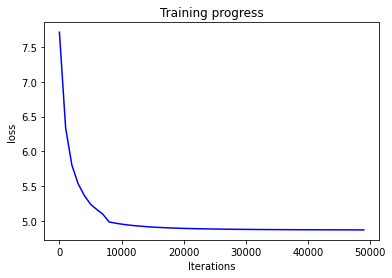

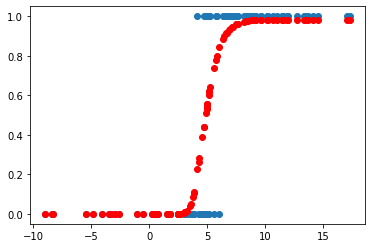

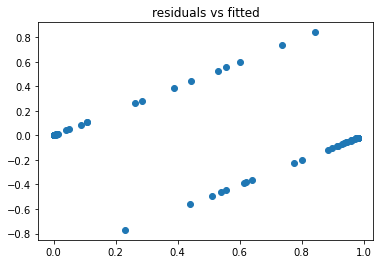

In [86]:
print(regr_net_2.get_evaluations())
regr_net_2.plot()
print(regr_net_1.predict(X = [[2,3,1,1,3,2]]))
plt.figure()
plt.scatter(x = X, y = y)
plt.scatter(x = X, y = regr_net_2.predict(X), c = 'r')
plt.figure()
residuals = regr_net_2.predict(X) - y
plt.scatter(x = regr_net_2.predict(X), y = residuals)
plt.title("residuals vs fitted")

# Multi categorical classification
- 3 categories
- softmax output 
- cross entropy loss
- 4 layers

In [88]:
# The last layer must be of size 3 for 3 categories
layers = [(3, sigmoid), (4, leaky_relu), (5, identity), (3, softmax)]

np.random.seed(9)
X = np.random.randn(3, 100)*5 + 5
maxima = np.argmax(X, axis = 0)

y = np.zeros_like(X)

for k in np.arange(y.shape[1]):
  y[maxima[k], k] = 1


In [91]:
class_net = NN(nr_features = 3, layers = layers, loss_function = cross_entropy)
class_net.train(X, y, nr_iterations = 50000, learning_rate = 0.0001, track = True)

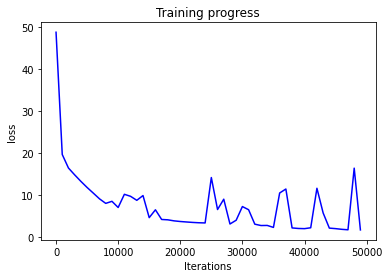

In [93]:
class_net.plot()

In [94]:
np.round(X[:,:8], 2), np.round(class_net.predict(X = X[:,:8]), 2), y[:,:8]

(array([[ 5.01,  3.55, -0.58,  4.94,  3.11,  2.59, -2.59,  2.55],
        [ 7.81,  6.2 ,  7.4 ,  5.31, -0.35, -1.37,  9.6 , 10.27],
        [-0.92, -0.15,  0.43,  0.88,  1.31,  9.29,  9.74, 10.98]]),
 array([[0.  , 0.  , 0.  , 0.01, 1.  , 0.  , 0.  , 0.  ],
        [1.  , 1.  , 1.  , 0.99, 0.  , 0.  , 0.14, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.86, 1.  ]]),
 array([[0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1.]]))

In [96]:
X.shape, y.shape

((3, 100), (3, 100))

Text(0.5, 1.0, 'residuals vs fitted')

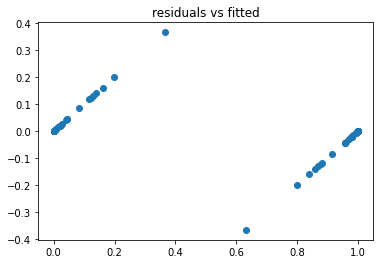

In [97]:
plt.figure()
residuals = class_net.predict(X) - y
plt.scatter(x = class_net.predict(X), y = residuals)
plt.title("residuals vs fitted")

In [237]:
def test_train_split(X, y, test_size = 0.2):
  assert 1/test_size % 1 == 0, 'test size does not allow for a cv split, chose a suitable division (e.g. 0.2)'
  nr_splits = int(1/test_size)
  test_n = X.shape[1]*test_size

  random_ind = np.random.choice(X.shape[1], size = X.shape[1], replace = False)

  partition = np.array(np.array_split(random_ind, nr_splits))

  train_sets = []
  test_sets = []

  for cv in np.arange(nr_splits):

    ind_test = cv
    ind_train = np.array(list(set(np.arange(nr_splits)) - set([cv])))

    test = random_ind[partition[ind_test]].flatten()
    train = random_ind[partition[ind_train]].flatten()

    test_sets.append((X[:,test], y[:,test]))
    train_sets.append((X[:,train], y[:,train]))

  return(test_sets, train_sets)




# Cross Validation

In [273]:
from matplotlib import cm

viridis = cm.get_cmap('viridis', 10)
viridis(0), viridis(0.1), viridis(1)

((0.267004, 0.004874, 0.329415, 1.0),
 (0.281412, 0.155834, 0.469201, 1.0),
 (0.281412, 0.155834, 0.469201, 1.0))

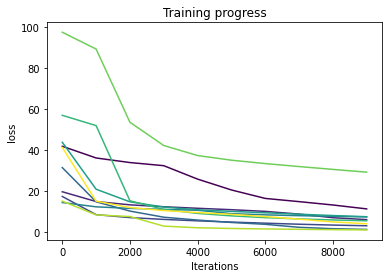

In [274]:
nr_folds = 10

test_sets, train_sets = test_train_split(X, y, test_size = 1/nr_folds)


cv_losses = []
for i in range(nr_folds):
  X_train, y_train = train_sets[i]
  X_test, y_test = test_sets[i] 
  cv_net = NN(nr_features = 3, layers = layers, loss_function = cross_entropy)
  cv_net.train(X_train, y_train, nr_iterations = 10000, learning_rate = 0.0001, track = True)
  cv_net.plot(color = viridis(i/nr_folds))
  y_pred = cv_net.predict(X_test)
  cv_losses.append(np.sum(cv_net.evaluate(y_test, y_pred)))


In [275]:
cv_losses

[11.513245438151275,
 12.785233246977057,
 5.329390703824865,
 0.6044586506129854,
 2.972094931947865,
 0.09851295546507377,
 0.6130341448260753,
 5.038509326918991,
 0.16751101822923606,
 0.17273638827172164]

In [276]:
np.mean(cv_losses)

3.9294726805225144